## Imports

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models 
from torch.utils.data import DataLoader
import os
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np
import random
import PIL

## Importing Data

In [2]:
#UNCOMMENT IF YOU NEED TO DOWNLOAD DATASET------------------------------------------------------------------------------------------------------
# #Download Dataset
# import opendatasets as od

# od.download("https://www.kaggle.com/datasets/aysendegerli/qatacov19-dataset/data")

In [3]:
from skimage import io

train_img_path = "/home/cahsi/Josh/Research/venv/Semantic_Segmentation_Research/Dataset/qatacov19-dataset/QaTa-COV19/QaTa-COV19-v2/Train Set/Images/*.png"
test_img_path = "/home/cahsi/Josh/Research/venv/Semantic_Segmentation_Research/Dataset/qatacov19-dataset/QaTa-COV19/QaTa-COV19-v2/Test Set/Images/*.png"

train_mask_path = "/home/cahsi/Josh/Research/venv/Semantic_Segmentation_Research/Dataset/qatacov19-dataset/QaTa-COV19/QaTa-COV19-v2/Train Set/Ground-truths/*.png"
test_mask_path = "/home/cahsi/Josh/Research/venv/Semantic_Segmentation_Research/Dataset/qatacov19-dataset/QaTa-COV19/QaTa-COV19-v2/Test Set/Ground-truths/*.png"

# Load all images in the current folder that end with .png
train_img = io.imread_collection(train_img_path)
test_img = io.imread_collection(test_img_path)
train_mask = io.imread_collection(train_mask_path)
test_mask = io.imread_collection(test_mask_path)

#Images Info
print("Length of training raw images: " + str(len(train_img)) + "      Shape of an training raw image: " + str(train_img[0].shape))
print("Length of training mask images: " + str(len(train_mask)) + "     Shape of an training mask image: " + str(train_mask[0].shape))

print("\nLength of test raw images: " + str(len(test_img)) + "       Shape of an test raw image: " + str(test_img[0].shape))
print("Length of test mask images: " + str(len(test_mask)) + "      Shape of an test mask image: " + str(test_mask[0].shape))

Length of training raw images: 7145      Shape of an training raw image: (224, 224)
Length of training mask images: 7145     Shape of an training mask image: (224, 224)

Length of test raw images: 2113       Shape of an test raw image: (224, 224)
Length of test mask images: 2113      Shape of an test mask image: (224, 224)


## Resizing Images

In [4]:
from skimage.transform import resize
import cv2

def resize_images(images, mask):
    output = []
    if mask:
        for mask in images:
            # Perform resizing with nearest neighbor interpolation to maintain binary values
            resized_mask = (resize(mask, (256, 256), order=0, anti_aliasing=False) > 0.5).astype(np.uint8)
            output.append(resized_mask)
    else:
        for image in images:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            resized_image = resize(image, (256, 256), anti_aliasing=False)
            output.append(resized_image)
    
    return output

# Resize training images to 256x256
train_images = np.array(resize_images(train_img, False))

# Resize testing images to 256x256
test_img = np.array(resize_images(test_img, False))

# Resize training masks to 256x256
train_masks = np.array(resize_images(train_mask, True))

# Resize testing masks to 256x256
test_mask = np.array(resize_images(test_mask, True))

In [6]:
#Print Shape of resized images
print("Shape of resized training raw image: " + str(train_images.shape))
print("Shape of resized training mask image: " + str(train_masks.shape))
print("Shape of resized testing raw image: " + str(test_img.shape))
print("Shape of resized testing mask image: " + str(test_mask.shape))

Shape of resized training raw image: (7145, 256, 256, 3)
Shape of resized training mask image: (7145, 256, 256)
Shape of resized testing raw image: (2113, 256, 256, 3)
Shape of resized testing mask image: (2113, 256, 256)


## Get Subset of Data

In [7]:
from sklearn.model_selection import train_test_split

#Convert to subset of data
subset_size = 0.20


#------------------>>>>> Comment if you want to use the full dataset for training
# train_images, _, train_masks, _ = train_test_split(train_img, train_mask, train_size=subset_size, random_state=25)

images = train_images
masks = train_masks

#Print Shape of resized images
print("Shape of resized training raw image: " + str(images.shape))
print("Shape of resized training mask image: " + str(masks.shape))

Shape of resized training raw image: (7145, 256, 256, 3)
Shape of resized training mask image: (7145, 256, 256)


## Create Datasets

In [8]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray((img * 255).astype(np.uint8)) for img in images],
    "mask": [Image.fromarray(mask) for mask in masks],
}


# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [9]:
#Check dataset info
print("Dataset Info:\n" + str(dataset))

Dataset Info:
Dataset({
    features: ['image', 'mask'],
    num_rows: 7145
})


## Visualize Data

In [10]:
import matplotlib.pyplot as plt
import numpy as np 

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

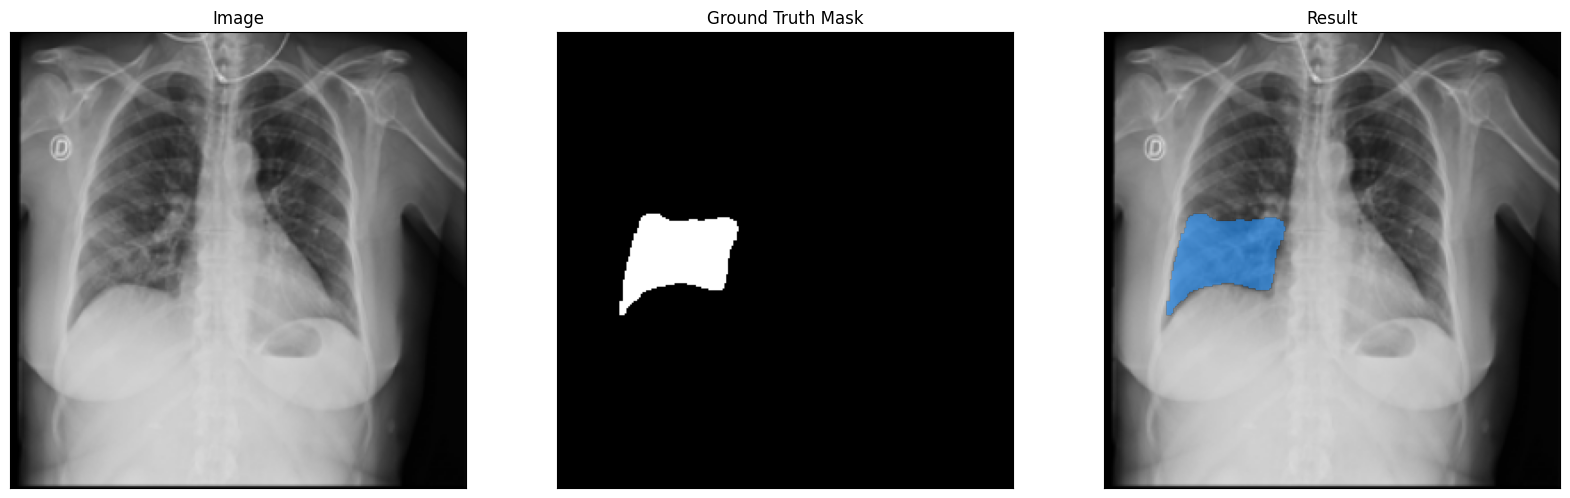

In [11]:
#Get random image from training set and plot
img_num = random.randint(0, images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["mask"]

fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image in the middle
axes[1].imshow(np.array(example_mask), cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Ground Truth Mask")

# Plot them overlapped on the right
axes[2].imshow(np.array(example_image), cmap='gray')  # Assuming the second image is grayscale
show_mask(np.array(example_mask), axes[2])
axes[2].set_title("Result")


# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

## Get Bounding Boxes

In [12]:
#Function that gets bounding boxes from masks
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [13]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["mask"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [14]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

print("Training: \n")
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

2024-04-22 22:32:59.543951: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 22:33:00.198700: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Training: 

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [15]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

print("Training: \n")
train_batch = next(iter(train_dataloader))
for k,v in train_batch.items():
  print(k,v.shape)

print("Ground Truth Mask Shape: " + str(train_batch["ground_truth_mask"].shape))

Training: 

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])
Ground Truth Mask Shape: torch.Size([2, 256, 256])


## Train Model

In [16]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [ ]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
import torch.nn as nn
from torch.nn.parallel import DataParallel
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 5
mean_epoch_loss = []

# Move your model to GPU devices
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:1")
model = model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
    mean_epoch_loss.append(mean_epoch_loss)

In [ ]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), f"/home/cahsi/Josh/Research/venv/Semantic_Segmentation_Research/SAM/sam_model_checkpoint_epoch{num_epochs}_datasize{subset_size}.pth")

## Inference

In [ ]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [ ]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
basic_sam_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
basic_sam_model.load_state_dict(torch.load(f"/home/cahsi/Josh/Research/venv/Semantic_Segmentation_Research/SAM/sam_model_checkpoint_epoch{num_epochs}_datasize{subset_size}.pth"))

In [ ]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
basic_sam_model.to(device)

In [ ]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, images.shape[0]-1)

# load image
test_image = dataset[idx]["image"]
test_image = np.array(test_image.convert("RGB"))


# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["mask"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

basic_sam_model.eval()

# forward pass
with torch.no_grad():
    outputs = basic_sam_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [ ]:
#Get Images
test_image = np.array(dataset[idx]["image"])
example_mask = np.array(dataset[idx]["mask"])

fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# Plot the first image on the left
axes[0].imshow(test_image, cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Ground Truth Mask")

# Plot the second image on the right
axes[2].imshow(test_image, cmap='gray')  # Assuming the second image is grayscale
show_mask(np.array(medsam_seg), axes[2])
axes[2].set_title("Predicted Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

### Further Analysis

In [ ]:
def calculateIoU(ground_mask, pred_mask):
        # Calculate the TP, FP, FN
        TP = 0
        FP = 0
        FN = 0
 
        for i in range(len(ground_mask)):
            for j in range(len(ground_mask[0])):
                if ground_mask[i][j] == 1 and pred_mask[i][j] == 1:
                    TP += 1
                elif ground_mask[i][j] == 0 and pred_mask[i][j] == 1:
                    FP += 1
                elif ground_mask[i][j] == 1 and pred_mask[i][j] == 0:
                    FN += 1
 
        # Calculate IoU
        iou = TP / (TP + FP + FN)
 
        return iou

In [ ]:
example_ground_mask = np.array(dataset[idx]["mask"])
print(f"IoU: {calculateIoU(example_ground_mask, medsam_seg)}")

### Testing on Test Dataset

In [ ]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
test_dataset_dict = {
    "image": [Image.fromarray((img * 255).astype(np.uint8)) for img in test_img[0:100]],
    "mask": [Image.fromarray(mask) for mask in test_mask[0:100]],
}

# Create the dataset using the datasets.Dataset class
test_dataset = Dataset.from_dict(test_dataset_dict)

In [ ]:
test_ious = []
model.to(device)
for idx, sample in enumerate(test_dataset):
    # Get Image and ground truth mask
    image = sample["image"]
    ground_truth_mask = np.array(sample["mask"])
    
    # get box prompt based on ground truth segmentation map
    prompt = get_bounding_box(ground_truth_mask)
    
    # prepare image + box prompt for the model
    inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
    #inputs = {k:v.squeeze(0) for k,v in inputs.items()}
    
    # forward pass
    with torch.no_grad():
      outputs = model(**inputs, multimask_output=False)
    # apply sigmoid
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

    iou = calculateIoU(ground_truth_mask, medsam_seg)
    print(f"Sample {idx} IoU: {iou}")
    test_ious.append(iou)

    
print(f"Average IoUs over 100 test sample: {mean(test_ious)}")

# Notes

**Model 1**
- **Epochs**:   5
- **Training Size**:    725 (0.03)
- **Mean loss**:    0.26717887695852693 
- **IoU**:  0.6352217576720984

##### Resources
<b> https://github.com/hitachinsk/SAMed

<b> https://github.com/MathieuNlp/Sam_LoRA

<b>https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb#scrollTo=aTXUX7xyCEGT